In [1]:
#Dedicated cell for import/libraries... should be able to hide this later
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sn
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.svm import SVC 
import csv
import math

# For producing decision tree diagrams.
from IPython.display import Image
import pydotplus
import graphviz
from io import StringIO
from sklearn.tree import export_graphviz
from pydot import graph_from_dot_data

In [2]:
df_weekly = pd.read_csv("WeeklyVars.csv")
df_quarterly = pd.read_csv("QuarterlyVars.csv")
df_weekly.info(verbose=True)
df_quarterly.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 16 columns):
Dates             983 non-null object
RLG Index         983 non-null float64
RLV Index         983 non-null float64
RTY Index         983 non-null float64
RIY Index         983 non-null float64
DXY Curncy        983 non-null float64
USGG10YR Index    983 non-null float64
USGG2YR Index     983 non-null float64
RR10CUS Index     983 non-null float64
USGGBE10 Index    983 non-null float64
VIX Index         983 non-null float64
CSI BARC Index    983 non-null float64
CSI BBB Index     983 non-null float64
CSI A Index       983 non-null float64
SHSZ300 Index     983 non-null float64
MSER Index        983 non-null float64
dtypes: float64(15), object(1)
memory usage: 123.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
Dates           75 non-null object
EHGDUS Index    75 non-null float64
dtypes: float64(1), object(1)
memory usage: 

In [3]:
# transform absolute index level to weekly changes
df_weekly['Dates'] = pd.to_datetime(df_weekly['Dates'])
df_weekly[['RLG Index', 'RLV Index', 'RTY Index', 'RIY Index', 'DXY Curncy','VIX Index', 
           'SHSZ300 Index', 'MSER Index']] = df_weekly[['RLG Index', 'RLV Index', 'RTY Index', 'RIY Index', 'DXY Curncy',
                                                       'VIX Index', 'SHSZ300 Index', 'MSER Index']].pct_change(1)
df_weekly[['USGG10YR Index', 'USGG2YR Index', 'RR10CUS Index', 'USGGBE10 Index', 'CSI BARC Index', 'CSI BBB Index',
           'CSI A Index']] = df_weekly[['USGG10YR Index', 'USGG2YR Index', 'RR10CUS Index', 'USGGBE10 Index',
                                        'CSI BARC Index', 'CSI BBB Index', 'CSI A Index']].diff()
df_weekly['US2v10YRspread'] = df_weekly['USGG10YR Index']-df_weekly['USGG2YR Index']

In [4]:
# Map QoQ GDP change to weekly df
df_weekly['DateUTC'] = pd.to_datetime(df_weekly['Dates'], utc=True)
df_quarterly['DateUTC'] = pd.to_datetime(df_quarterly['Dates'], utc=True)


In [5]:
df_quarterly = pd.DataFrame(df_weekly['DateUTC']).merge(df_quarterly, on='DateUTC', how='outer')

In [6]:
df_quarterly[df_quarterly['EHGDUS Index'].isnull()]['EHGDUS Index']= np.NaN
df_quarterly=df_quarterly.sort_values(by="DateUTC")
df_quarterly['EHGDUS Index'] = df_quarterly['EHGDUS Index'].fillna(method='ffill')

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
df = df_weekly.merge(df_quarterly, on='DateUTC', how='left')

In [8]:
df = df.iloc[1:]
df = df.drop(['DateUTC', 'Dates_y'], axis=1)

In [9]:
df.rename(columns={'RLG Index':'GrowthReturn','RLV Index':'ValueReturn','RTY Index':'SmallReturn',
                        'RIY Index':'LargeReturn','DXY Curncy':'USDReturn', 'USGG10YR Index':'US10yrChg',
                        'USGG2YR Index':'US2yrChg', 'RR10CUS Index':'RealRateChg', 
                        'USGGBE10 Index':'BreakevenChg', 'VIX Index':'VIXreturn', 'CSI BARC Index':'USHYSpreadChg',
                        'CSI BBB Index':'USBBBSpreadChg', 'CSI A Index':'USASpreadChg', 'SHSZ300 Index':'SHSZ300Return',
                        'MSER Index':'EuroMktReturn', 'US2v10YRspread':'2v10YRspreadChg', 'EHGDUS Index': 'QoQGDPChg'},
          inplace=True)
df.describe()

,GrowthReturn,ValueReturn,SmallReturn,LargeReturn,USDReturn,US10yrChg,US2yrChg,RealRateChg,BreakevenChg,VIXreturn,USHYSpreadChg,USBBBSpreadChg,USASpreadChg,SHSZ300Return,EuroMktReturn,2v10YRspreadChg,QoQGDPChg
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,970.000000
mean,0.002405,0.001593,0.002308,0.002009,-0.000027,-0.002510,-0.001276,-0.004725,0.000988,0.010488,-0.005468,-0.001354,-0.000804,0.002155,0.001102,-0.001234,2.068557
std,0.024120,0.025589,0.031595,0.024201,0.010904,0.115183,0.092023,0.137747,0.079699,0.158036,0.336958,0.078119,0.066843,0.034806,0.028073,0.080582,5.872669
min,-0.165978,-0.198277,-0.165441,-0.182174,-0.043300,-0.537500,-0.514000,-1.270000,-0.672300,-0.426630,-1.830000,-0.470000,-0.500000,-0.150067,-0.219194,-0.428500,-31.200000
25%,-0.009070,-0.008936,-0.013406,-0.008346,-0.007415,-0.074900,-0.038100,-0.080000,-0.037750,-0.081010,-0.137500,-0.030000,-0.020000,-0.017027,-0.013564,-0.047775,1.200000
50%,0.003053,0.002738,0.003646,0.003142,-0.000223,-0.006250,0.000000,-0.010000,0.000450,-0.010278,-0.020000,0.000000,0.000000,0.001452,0.003064,-0.008250,2.300000
75%,0.015359,0.013609,0.019251,0.014302,0.006545,0.065200,0.041300,0.070000,0.041650,0.071092,0.120000,0.020000,0.020000,0.021121,0.016177,0.042300,3.400000
max,0.113698,0.146424,0.185041,0.125853,0.048864,0.402900,0.658200,0.580000,0.459000,1.348361,3.000000,1.270000,1.060000,0.162130,0.115916,0.304000,33.800000


<Figure size 864x864 with 0 Axes>

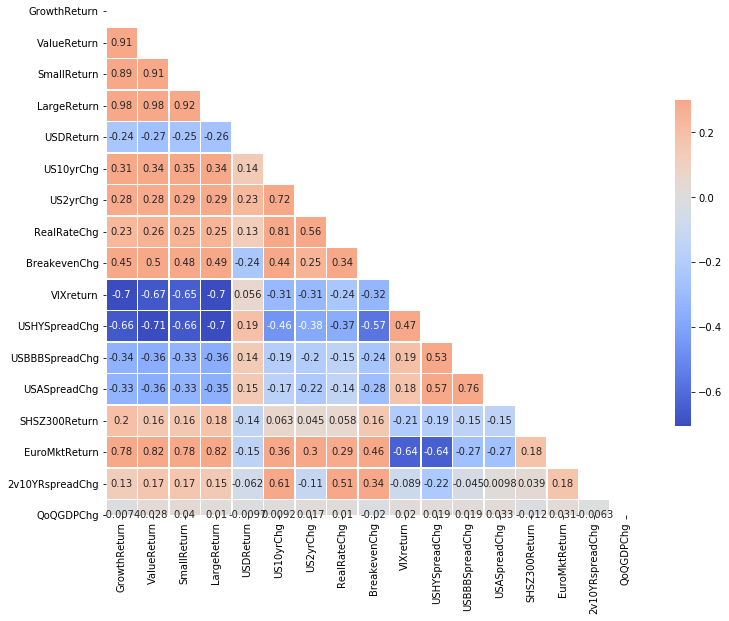

In [10]:
#Explore correlations 
plt.figure(figsize=(12,12))
corr = df.corr() 
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap='coolwarm'
#cmap="warm"
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Observations:

Macro variables that are highly correlated to the 4 target variables:

Negatively correlated:

- VIX index return
- US HY spread change
- US BBB spread change
- US A spread change
- USD return

Positive correlated:

- Europe Dev Market return
- SHSZ300 index return
- US 10yr breakeven
- US 2yr yield, US 10yr yield

Low correlation:

- QoQ GDP change
- 2yr vs 10yr spread change
- 10yr real rate

### Transformation and removal

**Convert Target variables to categorical based on the strongest return:**

1. Growth outperform
2. Value outperform
3. Small-cap outperform
4. Large-cap outperform

**Feature variable transformation:**

- take average of the US HY, BBB and A variables since they are highly correlated to each other.

Consider to remove the variables that have low correlation with the target variables. While they may not produce significant info gain, they may cause multi-collinearity as they have high correlation with other feature variables.

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


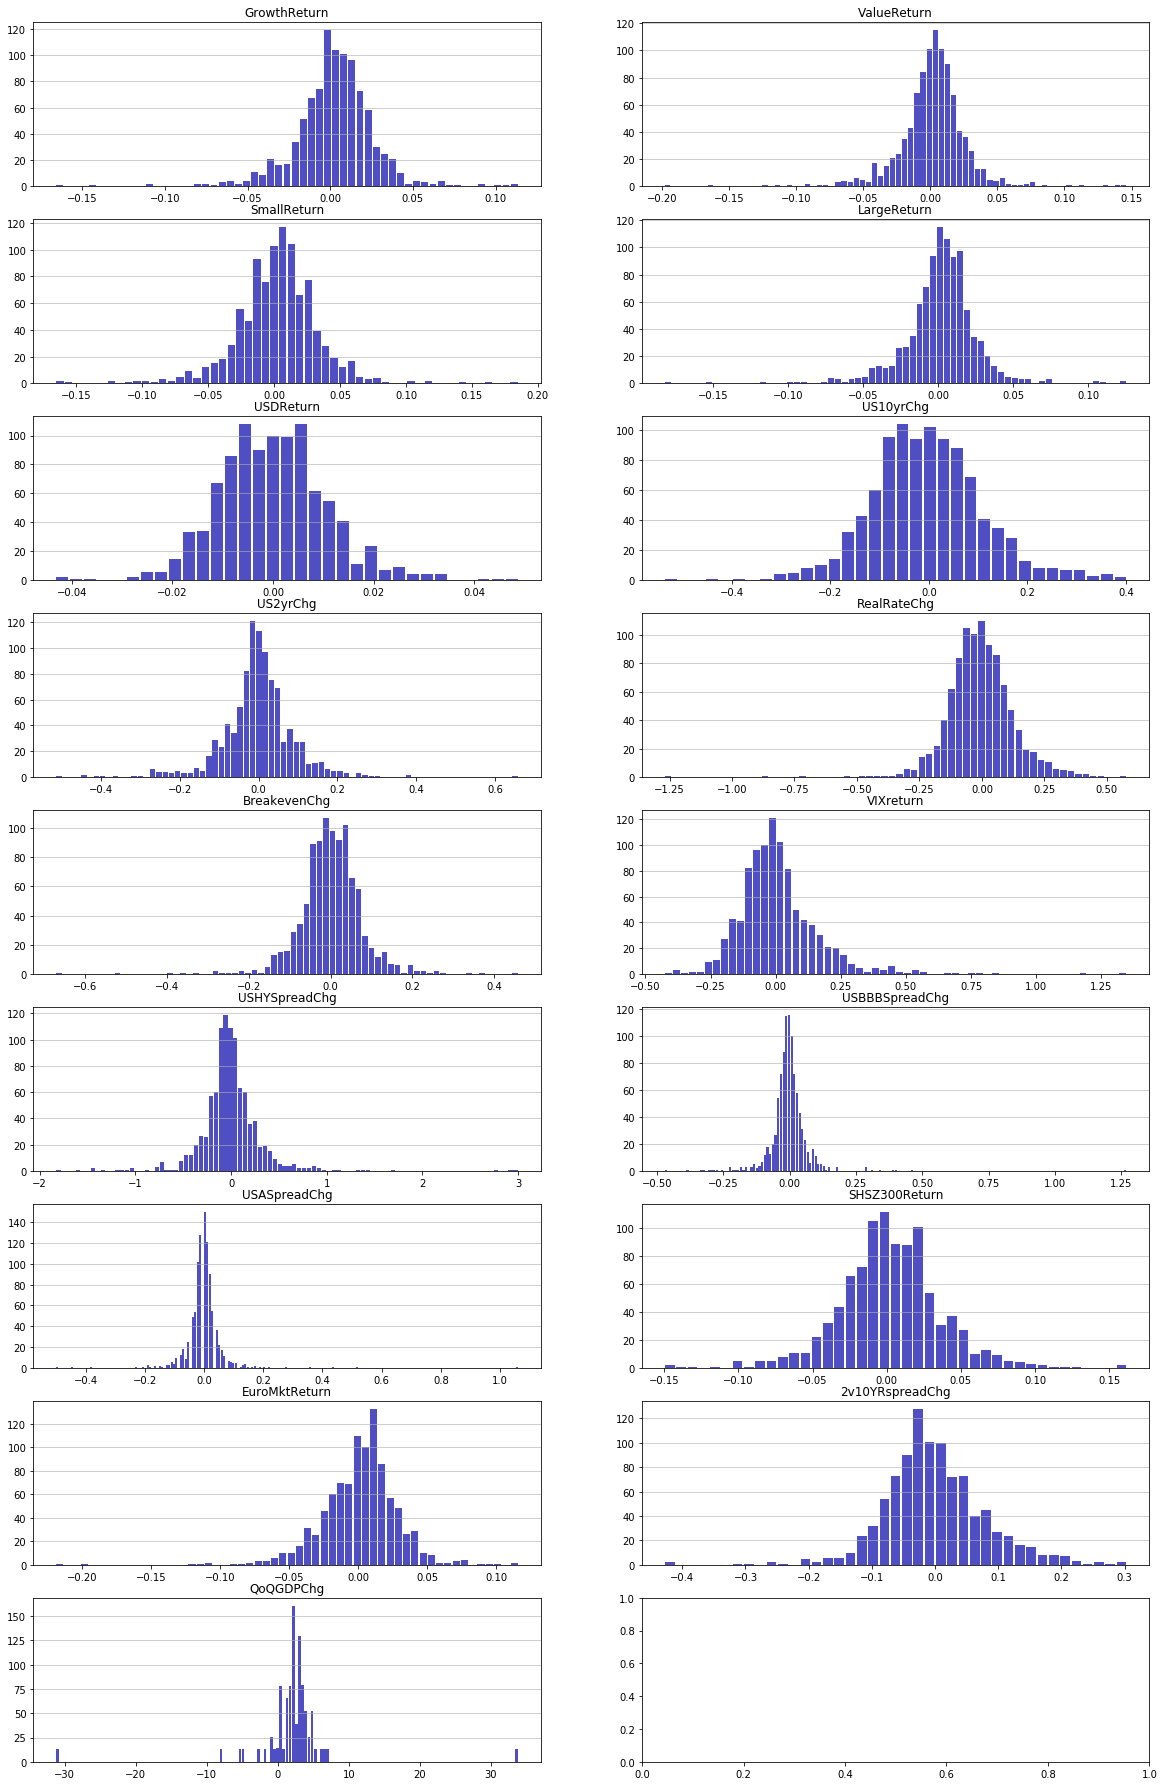

In [11]:
# Now, run univariate analysis
def histograms(df, N, figureSize):

    fig, axs = plt.subplots(math.ceil(N/2), 2, figsize=figureSize)
    axs = axs.ravel()
    for i in range(N):
        axs[i].hist(df.iloc[:,i], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
        axs[i].grid(axis='y', alpha=0.75)
        axs[i].set_title(df.columns[i])

histograms(df.iloc[:,1:], np.shape(df.iloc[:,1:])[1], (20, 32))

In [12]:
df['AvgCorpSpreadChg'] = df[['USHYSpreadChg', 'USBBBSpreadChg', 'USASpreadChg']].mean(axis=1)
df['Target'] = df.iloc[:,1:5].idxmax(axis = 1)

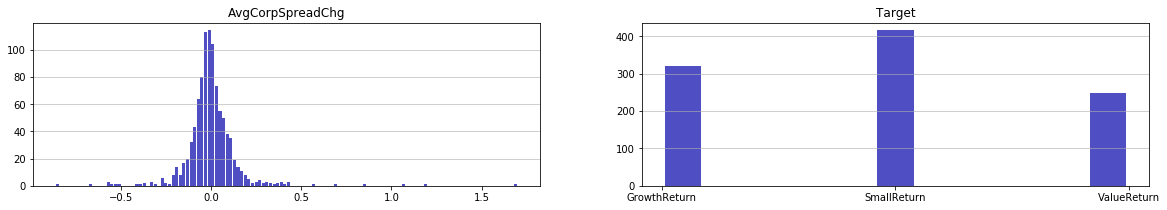

In [13]:
histograms(df.iloc[:,-2:], np.shape(df.iloc[:,-2:])[1], (20, 3))

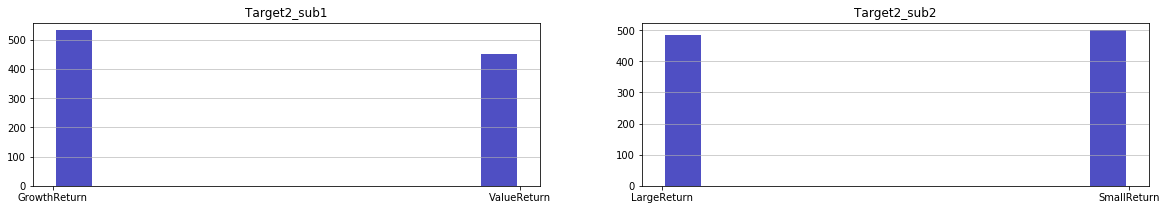

In [14]:
df['Target2_sub1'] = df.iloc[:,1:3].idxmax(axis = 1)
df['Target2_sub2'] = df.iloc[:,3:5].idxmax(axis = 1)
histograms(df.iloc[:,-2:], 2, (20, 3))

In [15]:
df.loc[df['Target2_sub1'] == 'GrowthReturn', 'Target2_sub1'] = "GrowthLead"
df.loc[df['Target2_sub1'] == 'ValueReturn', 'Target2_sub1'] = "ValueLead"

df.loc[df['Target2_sub2'] == 'SmallReturn', 'Target2_sub2'] = "SmallLead"
df.loc[df['Target2_sub2'] == 'LargeReturn', 'Target2_sub2'] = "LargeLead"

df['Target2'] = df['Target2_sub1'] + "," + df['Target2_sub2']

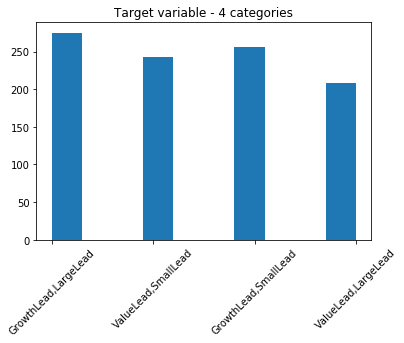

In [16]:
p = plt.hist(df['Target2'])
plt.title('Target variable - 4 categories')
plt.xticks(rotation=45)
plt.show()

In [17]:
label_ref = list(set(df['Target2']))
for i in range(len(label_ref)):
    df.loc[df['Target2'] == label_ref[i], 'Target2_num'] = int(i)
labels = df['Target2_num']

features = df[['USDReturn','BreakevenChg','VIXreturn','SHSZ300Return','EuroMktReturn','2v10YRspreadChg', 'AvgCorpSpreadChg']]
#,'QoQGDPChg'
train_features, dev_features, train_labels, dev_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42)


In [33]:
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90],
            'min_samples_leaf':[3,4,5,6,7,9,12]}
import itertools 
def parameter_search(train_features, train_labels, dev_features, dev_labels, tree_para):
    # Create a dictionary combination of the parameter grid
    parameter_names = list(tree_para.keys())
    v = tree_para.values()
    parameters = list(itertools.product(*v))

    for p in parameters:
        clf = DecisionTreeClassifier(max_depth = p[0], criterion='entropy', min_samples_leaf=p[1])
        clf.fit(train_features, train_labels)
        clf_preds = clf.predict(dev_features)
        print ('\nMax_depth:', p[0], "Min_samples_leaf:", p[1])
        print ('Accuracy on train data:', clf.score(train_features, train_labels))
        print ('Accuracy on dev data:', clf.score(dev_features, dev_labels))

parameter_search(train_features, train_labels, dev_features, dev_labels, tree_para)



Max_depth: 4 Min_samples_leaf: 3
Accuracy on train data: 0.39490445859872614
Accuracy on dev data: 0.3147208121827411

Max_depth: 4 Min_samples_leaf: 4
Accuracy on train data: 0.39490445859872614
Accuracy on dev data: 0.3147208121827411

Max_depth: 4 Min_samples_leaf: 5
Accuracy on train data: 0.39490445859872614
Accuracy on dev data: 0.3147208121827411

Max_depth: 4 Min_samples_leaf: 6
Accuracy on train data: 0.39490445859872614
Accuracy on dev data: 0.3147208121827411

Max_depth: 4 Min_samples_leaf: 7
Accuracy on train data: 0.3885350318471338
Accuracy on dev data: 0.3197969543147208

Max_depth: 4 Min_samples_leaf: 9
Accuracy on train data: 0.3872611464968153
Accuracy on dev data: 0.3197969543147208

Max_depth: 4 Min_samples_leaf: 12
Accuracy on train data: 0.37452229299363055
Accuracy on dev data: 0.29949238578680204

Max_depth: 5 Min_samples_leaf: 3
Accuracy on train data: 0.42929936305732486
Accuracy on dev data: 0.3096446700507614

Max_depth: 5 Min_samples_leaf: 4
Accuracy on tr

Max_depth: 15 Min_samples_leaf: 12
Accuracy on train data: 0.5031847133757962
Accuracy on dev data: 0.2639593908629442

Max_depth: 20 Min_samples_leaf: 3
Accuracy on train data: 0.7974522292993631
Accuracy on dev data: 0.27411167512690354

Max_depth: 20 Min_samples_leaf: 4
Accuracy on train data: 0.7426751592356687
Accuracy on dev data: 0.27411167512690354

Max_depth: 20 Min_samples_leaf: 5
Accuracy on train data: 0.6802547770700637
Accuracy on dev data: 0.3147208121827411

Max_depth: 20 Min_samples_leaf: 6
Accuracy on train data: 0.6382165605095541
Accuracy on dev data: 0.3147208121827411

Max_depth: 20 Min_samples_leaf: 7
Accuracy on train data: 0.6076433121019108
Accuracy on dev data: 0.3248730964467005

Max_depth: 20 Min_samples_leaf: 9
Accuracy on train data: 0.5528662420382165
Accuracy on dev data: 0.28426395939086296

Max_depth: 20 Min_samples_leaf: 12
Accuracy on train data: 0.5031847133757962
Accuracy on dev data: 0.2639593908629442

Max_depth: 30 Min_samples_leaf: 3
Accuracy 

In [53]:

decision_tree = DecisionTreeClassifier(max_depth = 20, criterion='entropy', min_samples_leaf=7)
decision_tree.fit(train_features, train_labels)

DT_preds = decision_tree.predict(dev_features)

In [54]:
print ('Accuracy on train data:', decision_tree.score(train_features, train_labels))
print ('Accuracy on dev data:', decision_tree.score(dev_features, dev_labels))

Accuracy on train data: 0.6076433121019108
Accuracy on dev data: 0.3197969543147208


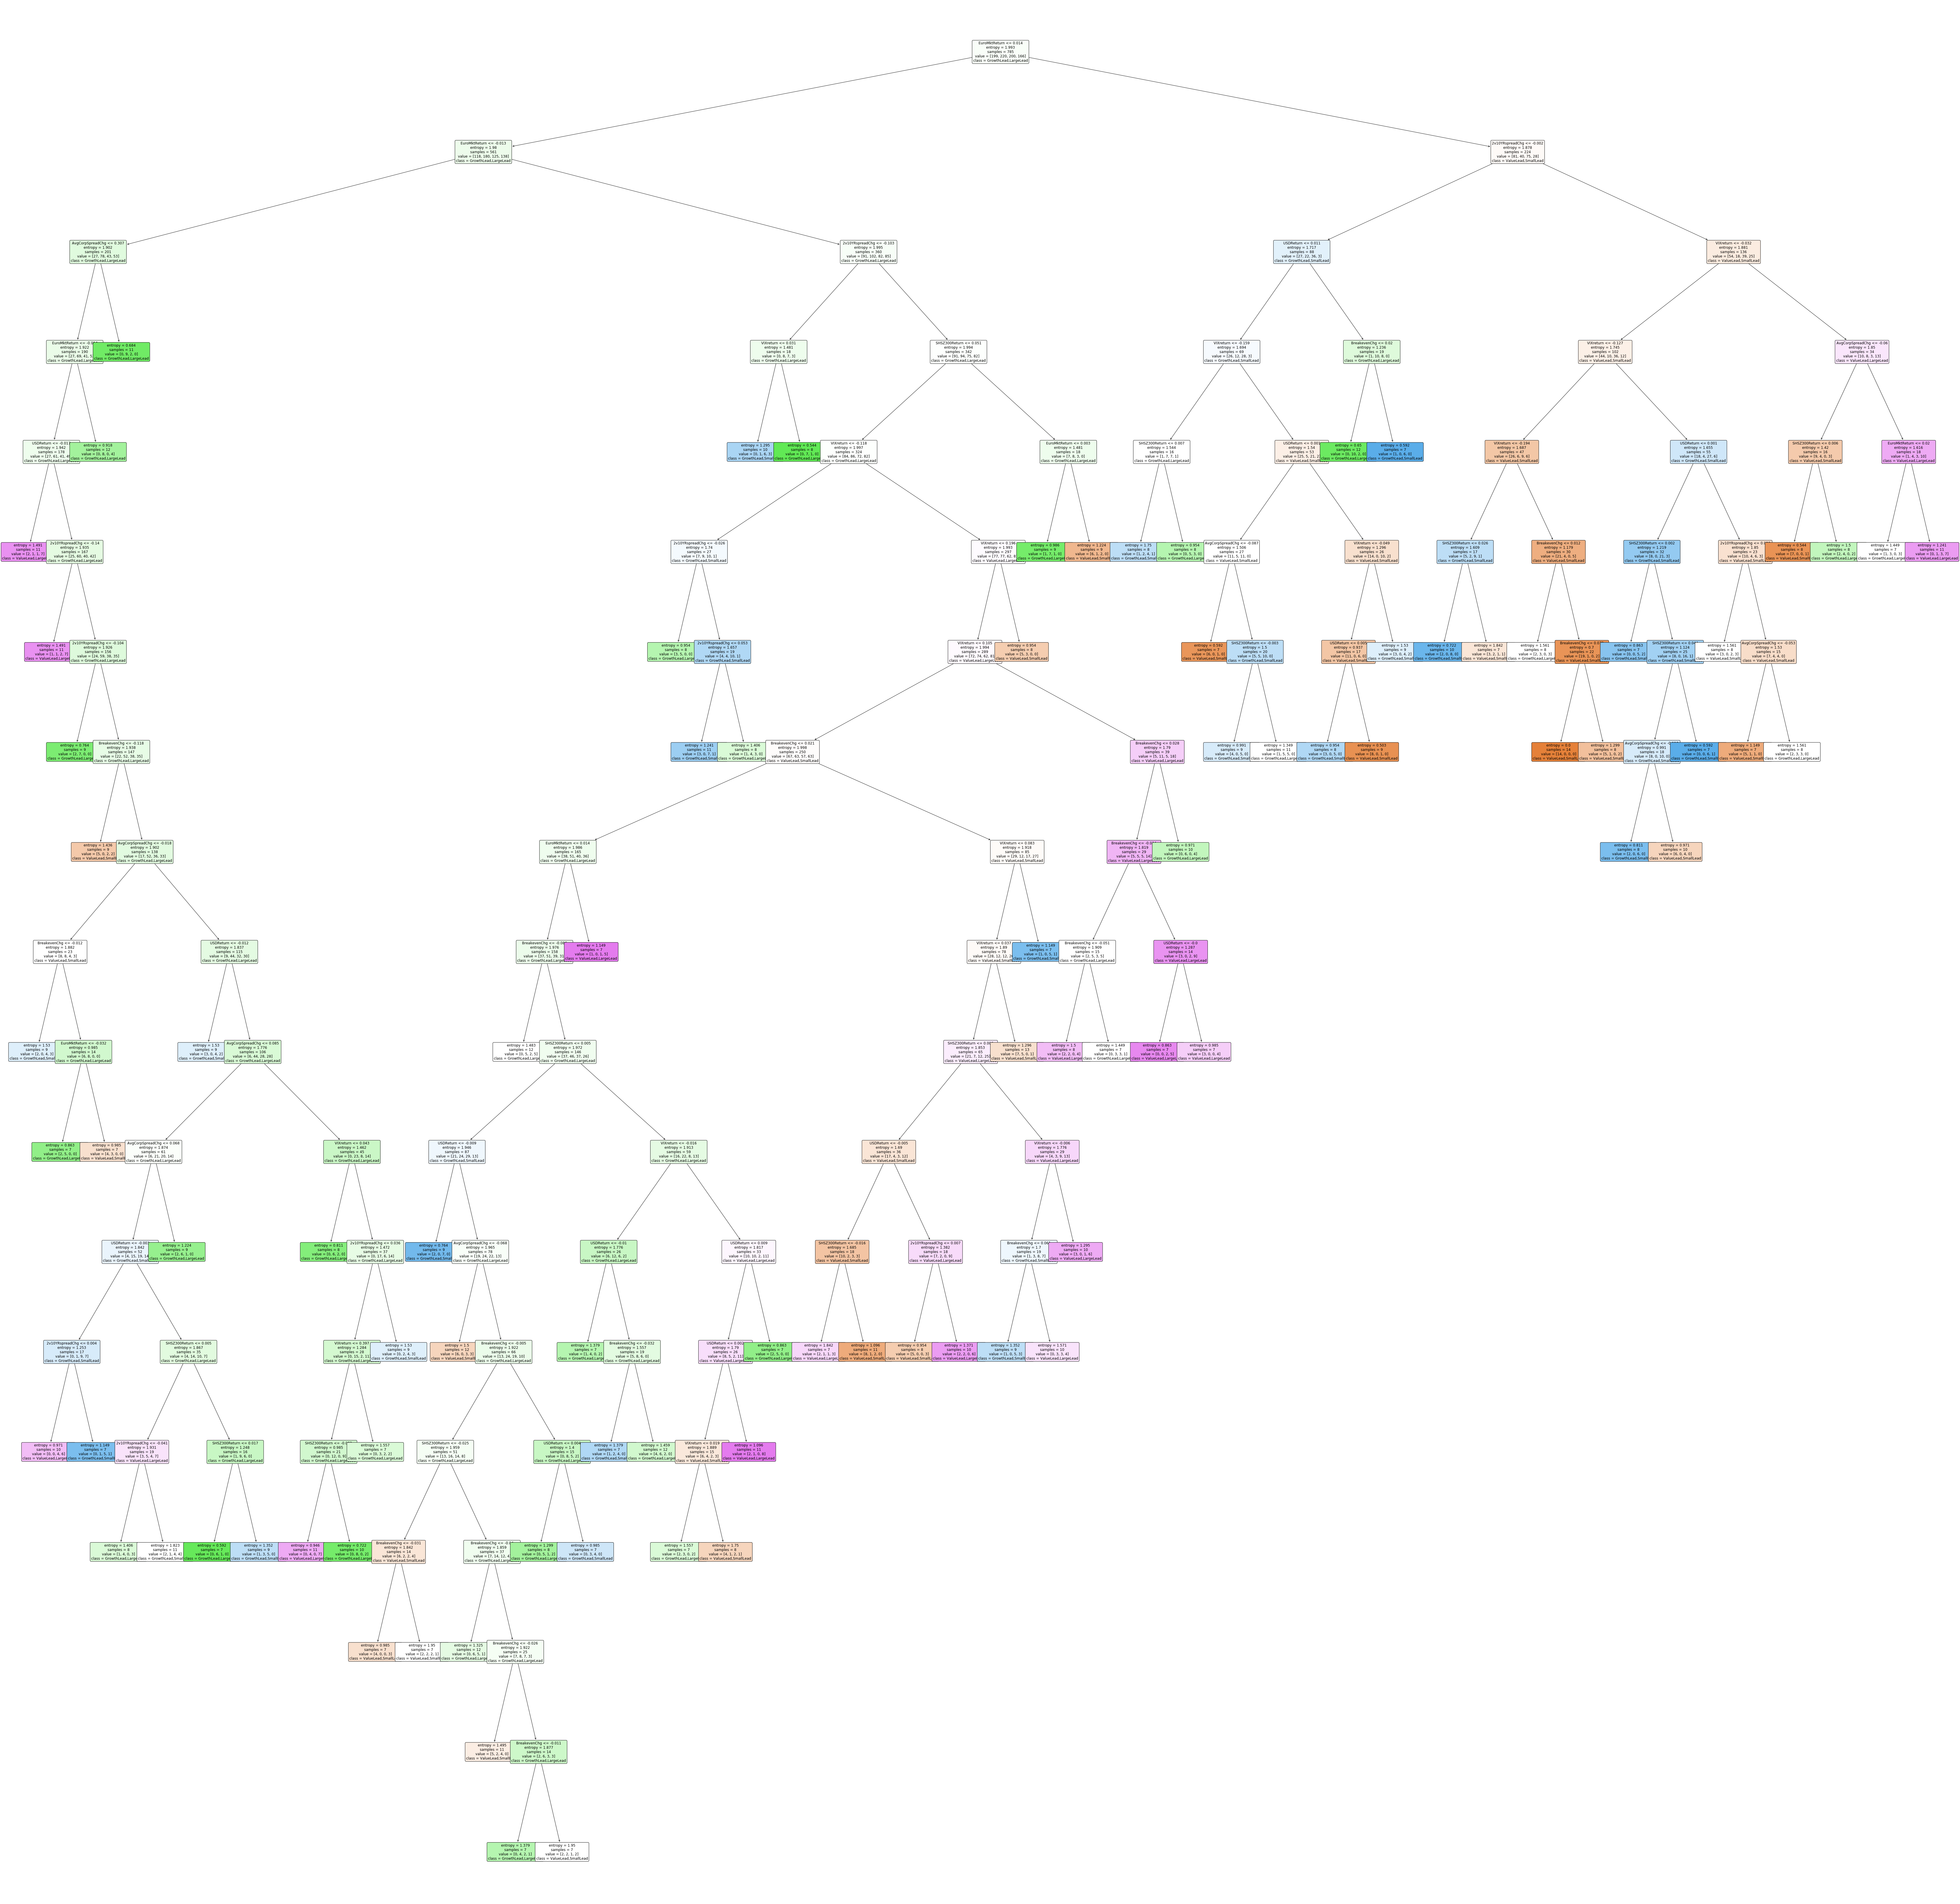

In [55]:
# Visualize the trained tree.

plt.figure(figsize=(120, 120))
tree.plot_tree(decision_tree, 
               filled=True, rounded=True, 
               feature_names = train_features.columns,class_names=label_ref,
               fontsize=12)
plt.show()

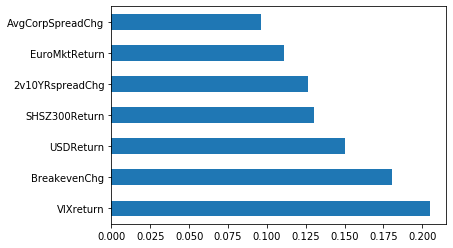

In [45]:
# get importance
feat_importances = pd.Series(decision_tree.feature_importances_, index=train_features.columns)
feat_importances.nlargest(20).plot(kind='barh')